# Data Exploration

## 0. Data overview
The data is taken from a [kaggle](https://www.kaggle.com/c/asap-aes) competition that the Hewlett Foundation held.
There are eight essay sets, each of the sets being generated from a single prompt. Some of the essays are responses to given readings wheareas others are answers to a short question.
All essays were hand graded by mutiple graders.

## 1.  Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
import os
import copy
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Import data

In [2]:
filename = 'datasources/training_set_rel3.tsv'
df = pd.read_csv(filename, encoding='iso-8859-1', delimiter='\t')  ## error with utf-8 encoding
print 'Data shape: ', df.shape
df.head()

Data shape:  (12976, 28)


,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# List of dataframes. Each dataframe contains data for each essay set.
dfs = []
dfs = [df[df['essay_set']==i+1] for i in range(8)]

# Turn essays into vector of features
vectorizers = [CountVectorizer() for i in range(8)]
corpuses = [dfs[i]['essay'].values for i in range(8)]
X = [vectorizers[i].fit_transform(corpuses[i]) for i in range(8)]
# We are going to use 'domain1_score' which is the resolved score between the graders as the response variable 
Y_orig = [dfs[i]['domain1_score'] for i in range(8)]

## 3. Basic Stats

In [4]:
columns = ['Essay set', 'Min score', 'Max score', 'Mean score', 'Mean length (words)']
basic_df = pd.DataFrame(columns=columns)
for i in range(8):
    # calculate basic stats for each
    max = Y_orig[i].max()
    min = Y_orig[i].min()
    mean = Y_orig[i].mean()
    mean_word_count = np.mean(X[i].sum(axis=1))
    # create new dataframe instance to append to basic_df
    new_df = pd.DataFrame([[i+1, min, max, mean, mean_word_count]], columns=columns)
    basic_df = basic_df.append(new_df)    
print basic_df.round(1).to_string(index=False)

 Essay set  Min score  Max score  Mean score  Mean length (words)
         1          2         12         8.5                353.1
         2          1          6         3.4                368.1
         3          0          3         1.8                105.7
         4          0          3         1.4                 92.4
         5          0          4         2.4                118.6
         6          0          4         2.7                150.5
         7          2         24        16.1                155.9
         8         10         60        37.0                572.7


## 4. Normalize Scores

In [5]:
# Normalize the score to 0.0 - 1.0 range.
Y = copy.deepcopy(Y_orig)
for i in range(len(Y)):
    max = Y_orig[i].max()
    min = Y_orig[i].min()
    a = 1.0/(max-min)
    b = float(-min)/(max-min)
    Y[i] *= a
    Y[i] += b

## 5. Data Exploration: Histograms
### 5.1 Essay Length

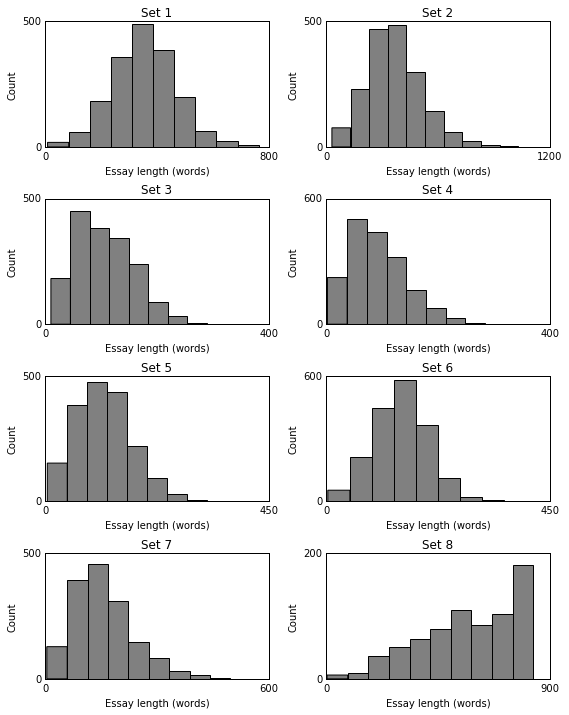

In [10]:
fig = plt.figure(figsize=(8, 10))

for i in range(8):
    # List of essay lengths (word counts)
    word_count = X[i].sum(axis=1)

    # Plot Essay length histogram
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(word_count, color='grey')

    ax.set_title('Set %d' %(i+1))
    ax.set_xlabel('Essay length (words)')
    ax.set_ylabel('Count')
    ax.grid()
    if i>=4:
        dummy=0
        #ax1.set_xlabel('Length (words)')
    if i==0 or i==4:
        dummy=0
        #ax1.set_ylabel('Count')
    ax.set_xticks([ax.get_xticks()[0], ax.get_xticks()[-1]])
    ax.set_yticks([ax.get_yticks()[0], ax.get_yticks()[-1]])

plt.tight_layout()
plt.show()

### 5.2 Score

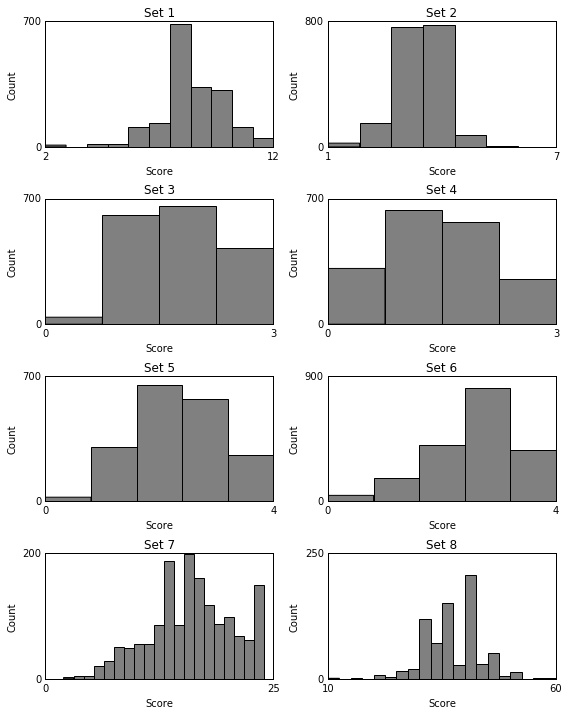

In [12]:
fig = plt.figure(figsize=(8, 6))

bins = [11, 6, 4, 4, 5, 5, 20, 20]

for i in range(8):
    # List of essay lengths (word counts)
    word_count = X[i].sum(axis=1)

    # Plot Essay length histogram
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(Y_orig[i], color='grey', bins=bins[i])

    ax.set_title('Set %d' %(i+1))
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.grid()
    if i>=4:
        dummy=0
        #ax1.set_xlabel('Length (words)')
    if i==0 or i==4:
        dummy=0
        #ax1.set_ylabel('Count')
    ax.set_xticks([ax.get_xticks()[0], ax.get_xticks()[-1]])
    ax.set_yticks([ax.get_yticks()[0], ax.get_yticks()[-1]])

plt.tight_layout()
plt.show()

---ADD COMMENT HERE---

## 6. Data exploration: Correlation to Score
### 6.1  Essay Length

Score vs Essay Length (word)


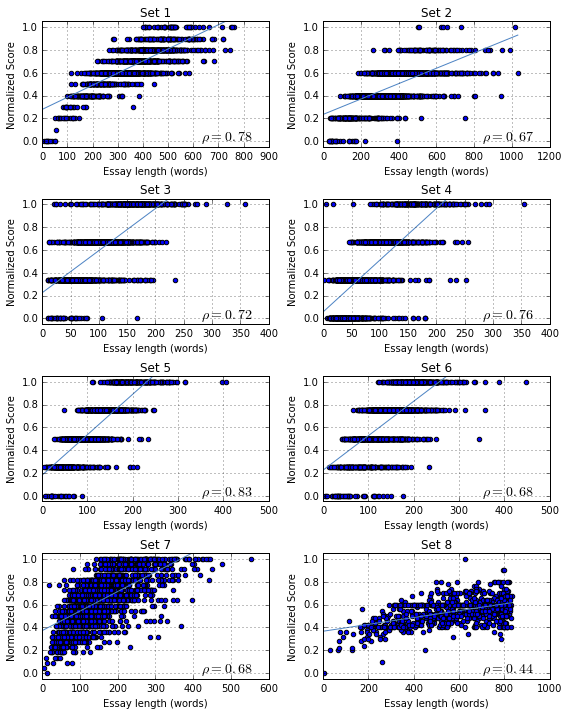

In [13]:
print 'Score vs Essay Length (word)'
fig = plt.figure(figsize=(8, 10))
for i in range(8):
    # List of essay lengths (word counts)
    word_count = X[i].sum(axis=1)
    
    # Plot Score vs Essay Length
    ax = fig.add_subplot(4, 2, i+1)
    ax.scatter(word_count, Y[i])
    
    # Linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(word_count, Y[i])
    a = lin_reg.coef_
    b = lin_reg.intercept_
    ax.plot([0, np.max(word_count)], [b, b+a*np.max(word_count)], color='#4E84C4', zorder=1)
    
    # Spearman's correlation for essay length and score
    rho = spearmanr(word_count, Y[i])[0]
    # Axis properties
    fontdict = {'fontsize':14}
    text = '$\\rho= %s$' % round(rho, 2)
    ax.text(0.7, 0.05, text, transform=ax.transAxes, fontdict=fontdict)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=-0.05, top=1.05)
    ax.set_title('Set %d' % (i+1))
    ax.set_xlabel('Essay length (words)')
    ax.set_ylabel('Normalized Score')
    ax.grid()
plt.tight_layout()
plt.show()

Essay length and score have moderate to strong positive correlations. It is clear that a successful model will have to incorporate more than just essay length in its grading scheme. More, the correlation coefficient varies greatly from one essay set to the next, meaning that the method we choose will have to adapt for different essay types.

### 6.2 Number of Unique Words

Score vs Number of Unique Words


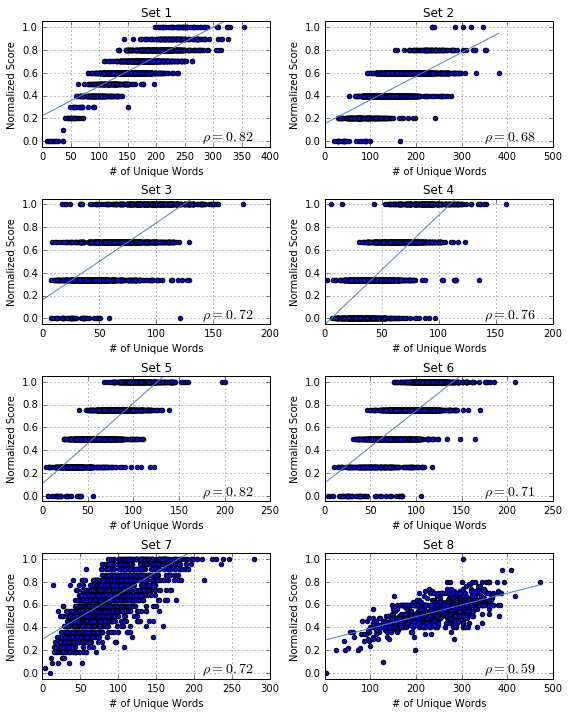

In [14]:
print 'Score vs Number of Unique Words'
fig = plt.figure(figsize=(8, 10))
for i in range(8):
    # List of number of unique words
    vocab_count = [X[i][j, :].count_nonzero() for j in range(X[i].shape[0])]
    vocab_count = np.reshape(vocab_count, (len(vocab_count), 1))
    
    # Plot Score vs Vocab size
    ax = fig.add_subplot(4, 2, i+1)
    ax.scatter(vocab_count, Y[i])
    
    # Linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(vocab_count, Y[i])
    a = lin_reg.coef_
    b = lin_reg.intercept_
    ax.plot([0, np.max(vocab_count)], [b, b+a*np.max(vocab_count)], color='#4E84C4', zorder=1)
    
    # Spearman correlation
    rho = spearmanr(vocab_count, Y[i])[0]
    
    # Axis properties
    fontdict = {'fontsize':14}
    text = '$\\rho= %s$' % round(rho, 2)
    ax.text(0.7, 0.05, text, transform=ax.transAxes, fontdict=fontdict)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=-0.05, top=1.05)
    ax.set_title('Set %d' % (i+1))
    ax.set_xlabel('# of Unique Words')
    ax.set_ylabel('Normalized Score')
    ax.grid()
plt.tight_layout()
plt.show()

Vocabulary size and score have moderate - strong positive correlations. Again, there is noticable variability in the correlation between vocabulary size and essay score among different essay types, meaning that our strategy will need to be different for each set.

One limitation of the visualizations provided here is that they do not take into account misspelled words. An essay riddled with spelling mistakes will likely have a low score, but have an artificially high vocabulary size as presented here, skewing the result. We will conduct a review of literature methods of counting mispellings to incorporate this measure.